## Binary Image Classification: Pizza vs. Ice Cream
Our goal is to build a binary image classifier. Through applying different machine learning classification techniques, we are hoping to differentiate between images of pizza and images of other food that is not pizza

#### Our dataset
We found our data on Kaggle. https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza The dataset contains 1966 images with an even split between images that are pizza and images that are not. Each image is 512 pixels on the longest side. 


#### Libraries that we are using

In [2]:
# for image manipulation
import cv2
from scipy import ndimage

# for displaying graphs and image
import matplotlib.pyplot as plt

# for machine learning
import sklearn

# general purpose 
import os
import numpy as np

(512, 512, 3)


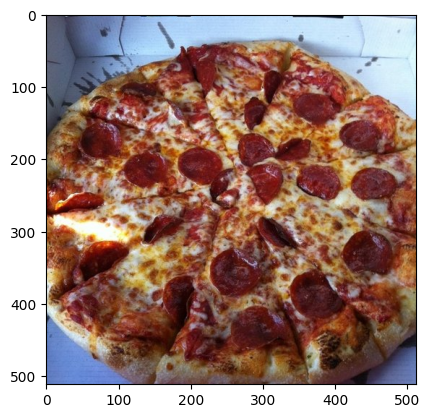

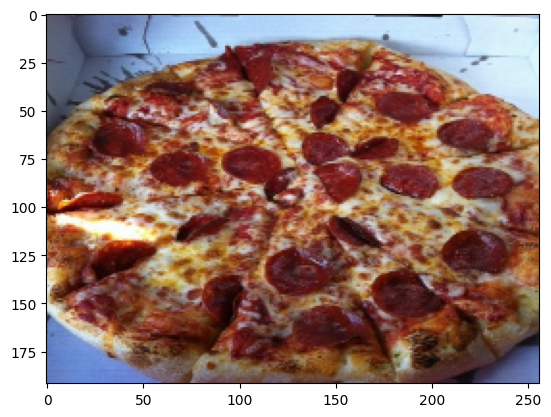

In [6]:
filename = "1001116.jpg"
test = cv2.imread("pizza_not_pizza/pizza/" + filename)
print(test.shape)

# show image in matplotlib plot
plt.imshow(cv2.cvtColor(test, cv2.COLOR_RGBA2BGR)) # channels in cv2 are reversed so has to be swapped
plt.show()

res_img = cv2.resize(test,(256, 192))
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_RGBA2BGR)) # channels in cv2 are reversed so has to be swapped
plt.show()

#### Transforming data
These steps will take the training data, transform it, and output the cleaned, ready to use data into a new dataset folder. In the dataset, the images are already resized to have a max length of 512 pixels, but we want images of exactly the same size. The transformation steps include rotating all images to be landscape, changing the aspect ratio of all images to 3:4, and decreasing resolution by half.

In [8]:
paths = ['/not_pizza/', '/pizza/']

for path in paths:
    os.makedirs('clean_data' + path, exist_ok=True)
    
    for filename in os.listdir("pizza_not_pizza" + path):
        # load image
        img = cv2.imread("pizza_not_pizza" + path + filename)
    
        # if the image is horizontal, rotate so it's vertical
        if img.shape[0] > img.shape[1]:
            rot_img = np.transpose(img, (1, 0, 2))  
        else:
            rot_img = img
        
        # Semi random decision, change if necessary
        # reshape all images to be 3:4 and about half of original dimensions, that is 192 by 256 
        # (since all original images have one dim that is 512)
        new_img = cv2.resize(rot_img,(256, 192)) # width by height so axes are swapped when passed in

        # write image to new directory, preserving dir structure & filenames
        new_path = 'clean_data' + path + filename
        cv2.imwrite(new_path, new_img)
    

#### Loading the data
Once the data is transformed and stored to a new folder, we load into X and create targets y.

In [3]:
# load in data
X = []
paths = ['/not_pizza/', '/pizza/']
for path in paths:
    for filename in os.listdir("clean_data" + path):
        # load image
        img_array = cv2.imread("clean_data" + path + filename)
        print(img_array.shape)
        X.append(img_array.flatten()) # flatten to 1D array
    print(f"files from {path} loaded")
    
X = np.array(X)
print(X.shape)

(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 

(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 

(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 

(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 256, 3)
(192, 

In [6]:
# create array of labels, with pizza as class 0 and ice cream as class 1
num_not_pizza = len([f for f in os.listdir("clean_data/not_pizza")])
num_pizza = len([f for f in os.listdir("clean_data/pizza")])

y = np.concatenate((np.zeros(num_not_pizza), np.ones(num_pizza)))

# make sure all data is loaded
assert len(y) == len(X)
assert len(X) == 1966

#### A Sample of the dataset
Here is a selection of images from both classes in the dataset

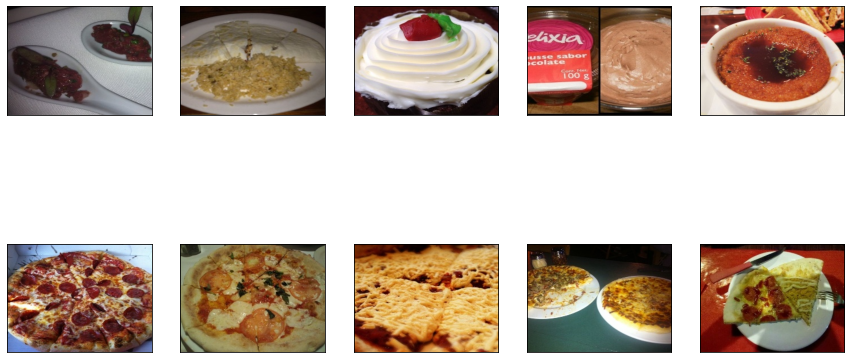

In [11]:
import matplotlib.pyplot as plt

not_pizza_imgs = X[0:5]
pizza_imgs = X[983:988]
together = np.concatenate((not_pizza_imgs, pizza_imgs))

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(y, together, axes.ravel()):
    img = np.reshape(image, (192, 256, 3))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGBA2BGR))
    #ax.set_title()

#### Implementing K Nearest Neighbors
For starters, we tried the K Nearest Neighbors approach because it was one of the simplest and allowed us to make sure we had loaded the dataset correctly

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)


0.6015228426395939

The score is ok (ranging from about .67 to .74). There's probably a way we can do this better.

#### Trying Principal Component Analysis
Hopefully using PCA we can find the most informative components and reduce the dimensionality of the data.

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200).fit(X_train) # keeps 200 most informative components

# data mapped onto pca space
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
# What can this tell us about our data?


In [14]:
# Trying KNN on this transformed data
knn_model_pca = KNeighborsClassifier(n_neighbors=3)
knn_model_pca.fit(X_train_pca, y_train)
knn_model_pca.score(X_test_pca, y_test)

0.6345177664974619

#### KNN w/o PCA Over Many Trials

In [30]:
i = 0
max_iter = 10
total = 0

while (i < max_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    knn_model = KNeighborsClassifier(n_neighbors=3)
    knn_model.fit(X_train, y_train)
    total = total + knn_model.score(X_test, y_test)
    i=i+1
    
total/max_iter

0.617005076142132

#### Implementing Support Vector Machines

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

#### Trying Support Vector Machines with Principal Component Analysis

In [13]:
from sklearn.svm import SVC

# all pixels will have same scale
# easier to do SVM with PCA because taking too long without PCA
svc = SVC()
svc.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_pca, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.75


In [ ]:
#### SVM with PCA over many trials

In [ ]:
i = 0
max_iter = 3
total_train = 0
total_test = 0

while (i < max_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    pca = PCA(n_components=200).fit(X_train) # keeps 200 most informative components
    # data mapped onto pca space
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    svc = SVC()
    svc.fit(X_train_pca, y_train)

    total_train = total_train + svc.score(X_train_pca, y_train)
    total_test = total_test + svc.score(X_test_pca, y_test)
    i=i+1
    
print("Accuracy on training set: {:.2f}".format(total_train/max_iter))
print("Accuracy on test set: {:.2f}".format(total_test/max_iter))

#### Implementing Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear").fit(X_train, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

#### Trying Principal Component Analysis

In [15]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear").fit(X_train_pca, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train_pca, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_pca, y_test)))

Training set score: 0.758
Test set score: 0.602


#### Implementing Neural Nets

In [27]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=200, alpha=.001, random_state=42, hidden_layer_sizes=([100, ]), solver = "lbfgs")
mlp.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

KeyboardInterrupt: 

#### Trying Principal Component Analysis

The following code tries neural nets with the defaul setting. 

In [15]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_pca, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.59


In the following code, we can adjust some of the settings. 

In [25]:
mlp = MLPClassifier(max_iter=10000, alpha=1, random_state=0, hidden_layer_sizes=([10, ]))
mlp.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_pca, y_test)))

Accuracy on training set: 0.960
Accuracy on test set: 0.571


#### Helpful Links to resources so far:
Generally:
+ https://scipy-lectures.org/advanced/image_processing/

For Principal Component Analysis:
+ https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d
+ https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
+ https://scikit-learn.org/stable/modules/decomposition.html#pca